# Data inputting and preparation

In [1]:
import csv
import random
import numpy as np

#specifying the input file for the algorithm
input_file = "Uni50a.dat"
input_data = []

#reading lines from input file into a 2D array 
for data in open(input_file).readlines():
    input_data.append(data.strip().split())

#finding the number of facilities from input file and calculating the expected length of array inputted
number_of_facilities = int(input_data[0][0])
expected_length = number_of_facilities * 2 + 3

#validating the length of input data matches to the expected length
if (len(input_data) == expected_length):
    #slicing input_array into distance matrix and flow matrix based on expected length
    temp_distance_matrix = input_data[2 : 2 + number_of_facilities]
    temp_flow_matrix = input_data[3 + number_of_facilities : 3 + number_of_facilities * 2]
    
#converting distance and flow matrix read from the file to a numpy array of intergers
distance_matrix = np.array(temp_distance_matrix).astype(int)
flow_matrix = np.array(temp_flow_matrix).astype(int)

In [2]:
#building the cost matrix for the problem by multiplying distance matrix and flow matrix
cost_matrix = np.multiply(distance_matrix, flow_matrix)
cost_matrix

array([[   0, 2037, 1900, ...,  880,  290, 6396],
       [2037,    0, 4510, ..., 7553, 4320, 6142],
       [1900, 4510,    0, ..., 1691, 3216,  588],
       ...,
       [ 880, 7553, 1691, ...,    0, 7520, 2120],
       [ 290, 4320, 3216, ..., 7520,    0,  120],
       [6396, 6142,  588, ..., 2120,  120,    0]])

In [3]:
#initializing the pheromone array by randomly distributing float between 0 and 1
#seed 10001 have been used to ensure the pheromone array can be rebuilt
pheromone_array = np.random.seed(10001)
pheromone_array = np.random.rand(distance_matrix.shape[0], distance_matrix.shape[1])

pheromone_array

array([[0.80726957, 0.11650697, 0.70428526, ..., 0.7953512 , 0.7355073 ,
        0.93915411],
       [0.49699265, 0.34107413, 0.98480849, ..., 0.61474237, 0.73746098,
        0.62175913],
       [0.31469773, 0.43719161, 0.14523088, ..., 0.94007221, 0.16231381,
        0.06747128],
       ...,
       [0.0020253 , 0.09873367, 0.94740147, ..., 0.82481393, 0.14186815,
        0.78496308],
       [0.23957556, 0.1674861 , 0.30481515, ..., 0.12976836, 0.25293337,
        0.67329301],
       [0.41139545, 0.36552982, 0.31990723, ..., 0.88078169, 0.10324117,
        0.38526712]])

# Main Ant Colony Optimization Function

In [4]:
#defining the ant colony class for the algorithm
class AntColony(object):
    def __init__(self, distances, pheromone, ant_path, iterations, evaporation):
        self.distances = distances #takes the distance matrix as the input
        self.pheromone = pheromone #takes the pheromone matrix as the input
        self.range = range(len(distances)) #finding the number of facilities for the problem 
        self.ant_path = ant_path #specifying the number of ants for the problem
        self.iterations = iterations #specifying the number of iterations
        self.evaporation = evaporation #specifying the evaporation rate for the problem
        
    def update_pheromone(self, all_paths):
        sorted_paths = sorted(all_paths, key = lambda x: x[1])
        
        for move in sorted_paths[0][0]:
            #flagging the special case where cost = 0 to prevent NaN in the pheromone array
            if cost_matrix[move] == 0:
                self.pheromone[move] = self.pheromone[move]
            else:
                #updating the pheromone by adding 1/fitness
                self.pheromone[move] += 1.0 / cost_matrix[move]
        
    def find_path_cost(self, path):
        total_cost = 0
        
        for move in path:
            #finding the total cost of a given path using for loop
            total_cost += cost_matrix[move[1]].sum() - cost_matrix[move]
            
        return total_cost
            
    def generate_all_paths(self):
        all_paths = []
        #randomly selecting the start node for the problem
        start_node = random.randrange(number_of_facilities)
        
        for i in range(self.ant_path):
            #calling the generate_path function for number of ants given
            path = self.generate_path(start_node)
            #appending the tuple of path and cost to an array
            all_paths.append((path, self.find_path_cost(path)))
            
        return all_paths
    
    def generate_path(self, start_node):
        path = []
        #creating a set named visited and adding start node to specify visited nodes
        visited = set()
        visited.add(start_node)
        previous = start_node
        
        for i in range(len(self.distances) - 1):
            #calling the pick_move function to pick move for the current ant
            move = self.pick_move(self.pheromone[previous], self.distances[previous], visited)
            path.append((previous, move))
            #setting previous to current move and adding it to the visited set
            previous = move
            visited.add(move)
            
        path.append((previous, start_node))
        return path
    
    def pick_move(self, pheromone, distance, visited):
        pheromone = np.copy(pheromone)
        #setting visited nodes in pheromone to 0
        pheromone[list(visited)] = 0       
        
        #normalizing the pheromone array by dividing the sum of pheromone
        normal_pheromone = pheromone / pheromone.sum()
        
        #calling the numpy choice function with normalized pheromone as the probability
        move = np.random.choice(number_of_facilities, 1, p = normal_pheromone)[0]
        
        return move
        
    def run(self):
        fitnesses = []
        lowest_fitness = None
        overall_lowest_fitness = ("Fitness", np.inf)
        
        #running the function while the termination criteria is not met
        for i in range(self.iterations):
            all_paths = self.generate_all_paths()
            self.update_pheromone(all_paths)
            lowest_fitness = min(all_paths, key = lambda x: x[1])
            fitnesses.append(lowest_fitness[1])
            
            if lowest_fitness[1] < overall_lowest_fitness[1]:
                overall_lowest_fitness = lowest_fitness
                
            #evaporating the pheromone by multiplying the pheromone array with the evaporation rate
            self.pheromone = self.pheromone * self.evaporation
            
        return overall_lowest_fitness, fitnesses

# Analysis of the Algorithm

In [5]:
import timeit
import matplotlib.pyplot as plt

# Experiment 1 (m = 100, e = 0.90)

Trial 1

Overall Best Fitness: 5720301
Time Used: 693.108414834 seconds


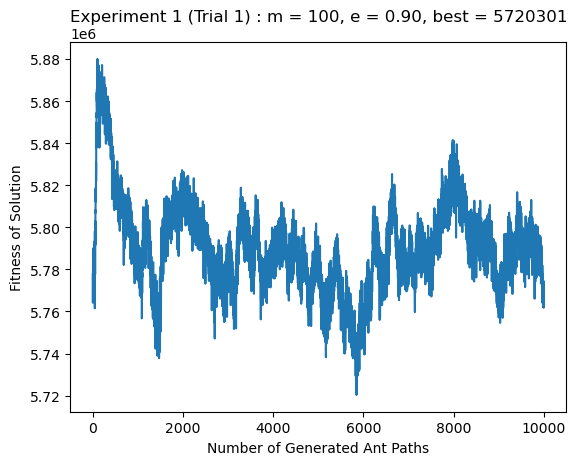

In [6]:
start_e1_t1 = timeit.default_timer()

aco_e1_t1 = AntColony(distance_matrix, pheromone_array, 100, 10000, 0.9)
overall_lowest_e1_t1, fitnesses_e1_t1 = aco_e1_t1.run()

end_e1_t1 = timeit.default_timer()

print("Overall Best Fitness: " + str(overall_lowest_e1_t1[-1]))
print("Time Used: " + str(end_e1_t1 - start_e1_t1) + " seconds")

plt.plot(fitnesses_e1_t1)
title = "Experiment 1 (Trial 1) : m = 100, e = 0.90, best = " + str(overall_lowest_e1_t1[-1])
plt.title(title, pad = 15.0)
plt.ylabel('Fitness of Solution')
plt.xlabel('Number of Generated Ant Paths')
plt.savefig("aco_e1_t1.png")
plt.show()

Trial 2

Overall Best Fitness: 5727796
Time Used: 692.159201417 seconds


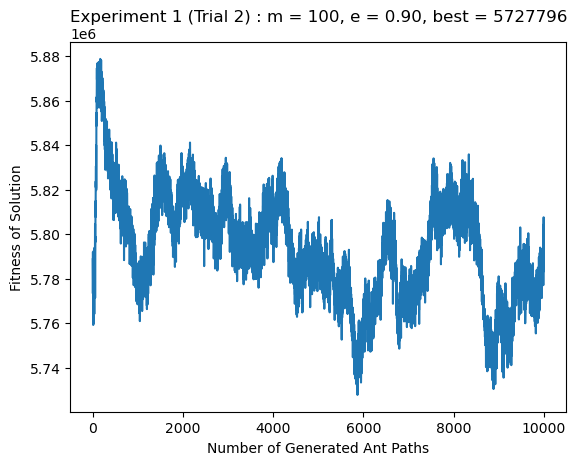

In [7]:
start_e1_t2 = timeit.default_timer()

aco_e1_t2 = AntColony(distance_matrix, pheromone_array, 100, 10000, 0.9)
overall_lowest_e1_t2, fitnesses_e1_t2 = aco_e1_t2.run()

end_e1_t2 = timeit.default_timer()

print("Overall Best Fitness: " + str(overall_lowest_e1_t2[-1]))
print("Time Used: " + str(end_e1_t2 - start_e1_t2) + " seconds")

plt.plot(fitnesses_e1_t2)
title = "Experiment 1 (Trial 2) : m = 100, e = 0.90, best = " + str(overall_lowest_e1_t2[-1])
plt.title(title, pad = 15.0)
plt.ylabel('Fitness of Solution')
plt.xlabel('Number of Generated Ant Paths')
plt.savefig("aco_e1_t2.png")
plt.show()

Trial 3

Overall Best Fitness: 5726111
Time Used: 690.4652548749998 seconds


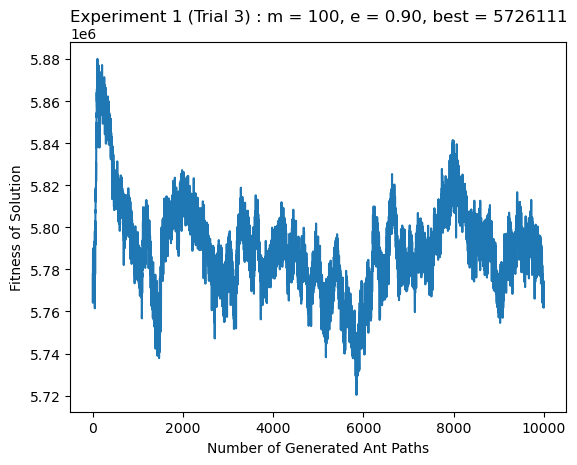

In [8]:
start_e1_t3 = timeit.default_timer()

aco_e1_t3 = AntColony(distance_matrix, pheromone_array, 100, 10000, 0.9)
overall_lowest_e1_t3, fitnesses_e1_t3 = aco_e1_t3.run()

end_e1_t3 = timeit.default_timer()

print("Overall Best Fitness: " + str(overall_lowest_e1_t3[-1]))
print("Time Used: " + str(end_e1_t3 - start_e1_t3) + " seconds")

plt.plot(fitnesses_e1_t1)
title = "Experiment 1 (Trial 3) : m = 100, e = 0.90, best = " + str(overall_lowest_e1_t3[-1])
plt.title(title, pad = 15.0)
plt.ylabel('Fitness of Solution')
plt.xlabel('Number of Generated Ant Paths')
plt.savefig("aco_e1_t3.png")
plt.show()

Trial 4

Overall Best Fitness: 5712388
Time Used: 687.5058867090002 seconds


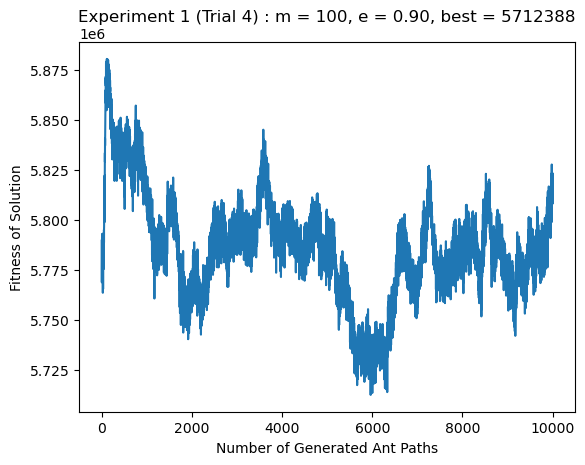

In [9]:
start_e1_t4 = timeit.default_timer()

aco_e1_t4 = AntColony(distance_matrix, pheromone_array, 100, 10000, 0.9)
overall_lowest_e1_t4, fitnesses_e1_t4 = aco_e1_t4.run()

end_e1_t4 = timeit.default_timer()

print("Overall Best Fitness: " + str(overall_lowest_e1_t4[-1]))
print("Time Used: " + str(end_e1_t4 - start_e1_t4) + " seconds")

plt.plot(fitnesses_e1_t4)
title = "Experiment 1 (Trial 4) : m = 100, e = 0.90, best = " + str(overall_lowest_e1_t4[-1])
plt.title(title, pad = 15.0)
plt.ylabel('Fitness of Solution')
plt.xlabel('Number of Generated Ant Paths')
plt.savefig("aco_e1_t4.png")
plt.show()

Trial 5

Overall Best Fitness: 5706746
Time Used: 688.076496917 seconds


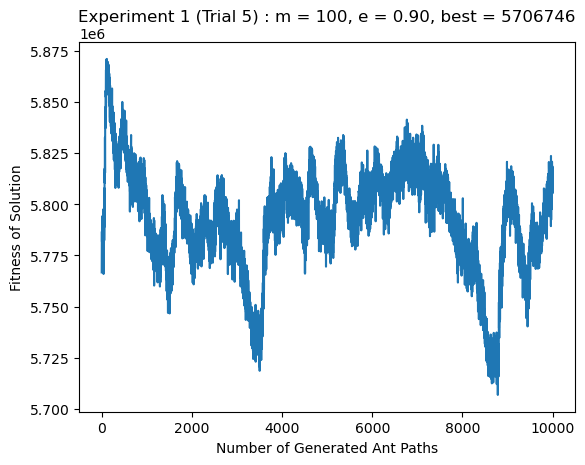

In [10]:
start_e1_t5 = timeit.default_timer()

aco_e1_t5 = AntColony(distance_matrix, pheromone_array, 100, 10000, 0.9)
overall_lowest_e1_t5, fitnesses_e1_t5 = aco_e1_t5.run()

end_e1_t5 = timeit.default_timer()

print("Overall Best Fitness: " + str(overall_lowest_e1_t5[-1]))
print("Time Used: " + str(end_e1_t5 - start_e1_t5) + " seconds")

plt.plot(fitnesses_e1_t5)
title = "Experiment 1 (Trial 5) : m = 100, e = 0.90, best = " + str(overall_lowest_e1_t5[-1])
plt.title(title, pad = 15.0)
plt.ylabel('Fitness of Solution')
plt.xlabel('Number of Generated Ant Paths')
plt.savefig("aco_e1_t5.png")
plt.show()

# Experiment 2 (m = 100, e = 0.50)

Trial 1

Overall Best Fitness: 5707348
Time Used: 686.6970676659998 seconds


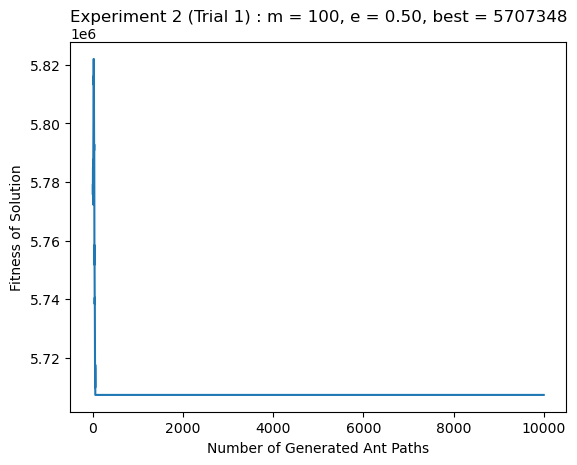

In [11]:
start_e2_t1 = timeit.default_timer()

aco_e2_t1 = AntColony(distance_matrix, pheromone_array, 100, 10000, 0.5)
overall_lowest_e2_t1, fitnesses_e2_t1 = aco_e2_t1.run()

end_e2_t1 = timeit.default_timer()

print("Overall Best Fitness: " + str(overall_lowest_e2_t1[-1]))
print("Time Used: " + str(end_e2_t1 - start_e2_t1) + " seconds")

plt.plot(fitnesses_e2_t1)
title = "Experiment 2 (Trial 1) : m = 100, e = 0.50, best = " + str(overall_lowest_e2_t1[-1])
plt.title(title, pad = 15.0)
plt.ylabel('Fitness of Solution')
plt.xlabel('Number of Generated Ant Paths')
plt.savefig("aco_e2_t1.png")
plt.show()

Trial 2

Overall Best Fitness: 5708824
Time Used: 687.4740242079997 seconds


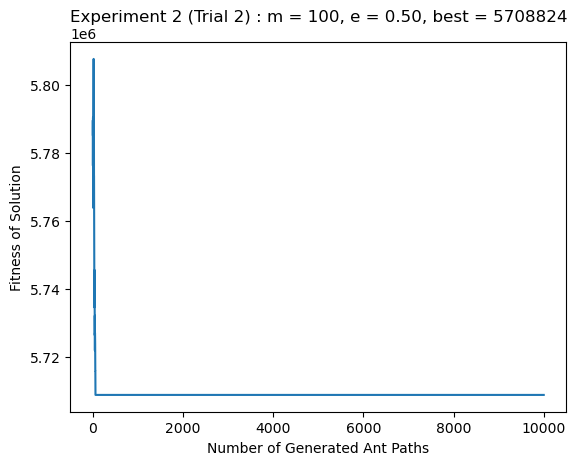

In [12]:
start_e2_t2 = timeit.default_timer()

aco_e2_t2 = AntColony(distance_matrix, pheromone_array, 100, 10000, 0.5)
overall_lowest_e2_t2, fitnesses_e2_t2 = aco_e2_t2.run()

end_e2_t2 = timeit.default_timer()

print("Overall Best Fitness: " + str(overall_lowest_e2_t2[-1]))
print("Time Used: " + str(end_e2_t2 - start_e2_t2) + " seconds")

plt.plot(fitnesses_e2_t2)
title = "Experiment 2 (Trial 2) : m = 100, e = 0.50, best = " + str(overall_lowest_e2_t2[-1])
plt.title(title, pad = 15.0)
plt.ylabel('Fitness of Solution')
plt.xlabel('Number of Generated Ant Paths')
plt.savefig("aco_e2_t2.png")
plt.show()

Trial 3

Overall Best Fitness: 5689706
Time Used: 686.2628748329998 seconds


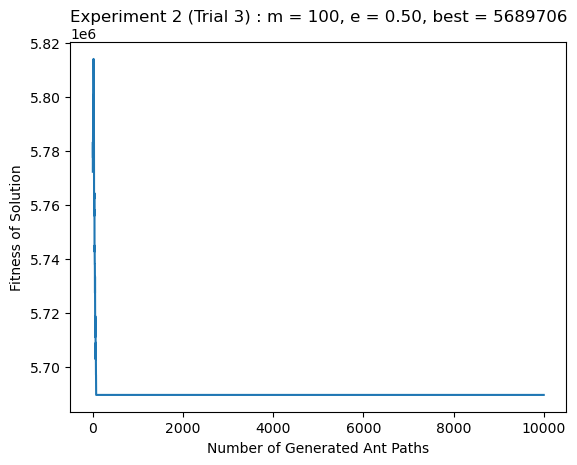

In [13]:
start_e2_t3 = timeit.default_timer()

aco_e2_t3 = AntColony(distance_matrix, pheromone_array, 100, 10000, 0.5)
overall_lowest_e2_t3, fitnesses_e2_t3 = aco_e2_t3.run()

end_e2_t3 = timeit.default_timer()

print("Overall Best Fitness: " + str(overall_lowest_e2_t3[-1]))
print("Time Used: " + str(end_e2_t3 - start_e2_t3) + " seconds")

plt.plot(fitnesses_e2_t3)
title = "Experiment 2 (Trial 3) : m = 100, e = 0.50, best = " + str(overall_lowest_e2_t3[-1])
plt.title(title, pad = 15.0)
plt.ylabel('Fitness of Solution')
plt.xlabel('Number of Generated Ant Paths')
plt.savefig("aco_e2_t3.png")
plt.show()

Trial 4

Overall Best Fitness: 5705313
Time Used: 685.7160305420002 seconds


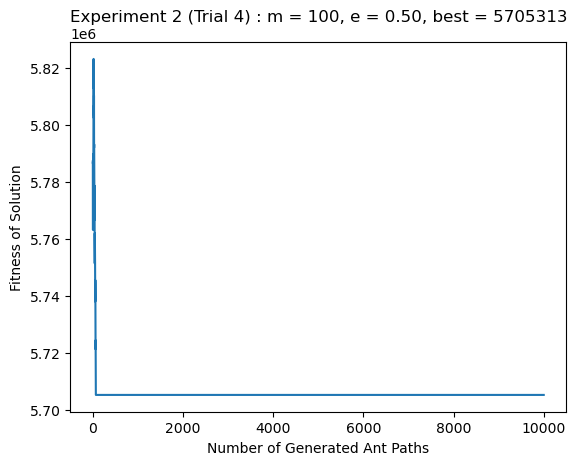

In [14]:
start_e2_t4 = timeit.default_timer()

aco_e2_t4 = AntColony(distance_matrix, pheromone_array, 100, 10000, 0.5)
overall_lowest_e2_t4, fitnesses_e2_t4 = aco_e2_t4.run()

end_e2_t4 = timeit.default_timer()

print("Overall Best Fitness: " + str(overall_lowest_e2_t4[-1]))
print("Time Used: " + str(end_e2_t4 - start_e2_t4) + " seconds")

plt.plot(fitnesses_e2_t4)
title = "Experiment 2 (Trial 4) : m = 100, e = 0.50, best = " + str(overall_lowest_e2_t4[-1])
plt.title(title, pad = 15.0)
plt.ylabel('Fitness of Solution')
plt.xlabel('Number of Generated Ant Paths')
plt.savefig("aco_e2_t4.png")
plt.show()

Trial 5

Overall Best Fitness: 5676573
Time Used: 685.7820746669995 seconds


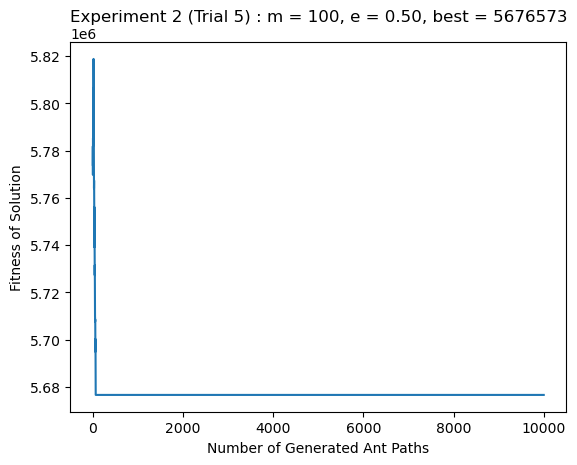

In [15]:
start_e2_t5 = timeit.default_timer()

aco_e2_t5 = AntColony(distance_matrix, pheromone_array, 100, 10000, 0.5)
overall_lowest_e2_t5, fitnesses_e2_t5 = aco_e2_t5.run()

end_e2_t5 = timeit.default_timer()

print("Overall Best Fitness: " + str(overall_lowest_e2_t5[-1]))
print("Time Used: " + str(end_e2_t5 - start_e2_t5) + " seconds")

plt.plot(fitnesses_e2_t5)
title = "Experiment 2 (Trial 5) : m = 100, e = 0.50, best = " + str(overall_lowest_e2_t5[-1])
plt.title(title, pad = 15.0)
plt.ylabel('Fitness of Solution')
plt.xlabel('Number of Generated Ant Paths')
plt.savefig("aco_e2_t5.png")
plt.show()

# Experiment 3 (m = 10, e = 0.90)

Trial 1

Overall Best Fitness: 5768990
Time Used: 70.3544430840002 seconds


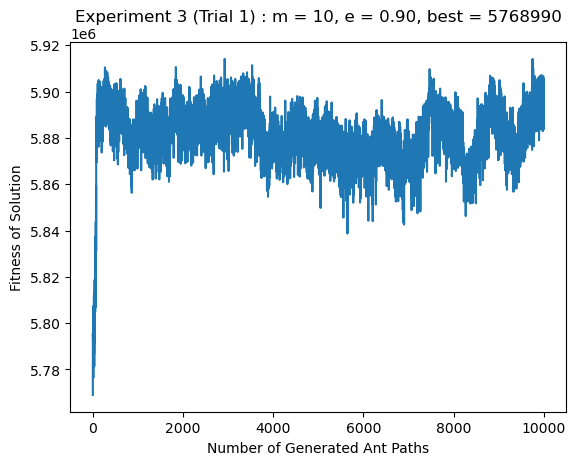

In [16]:
start_e3_t1 = timeit.default_timer()

aco_e3_t1 = AntColony(distance_matrix, pheromone_array, 10, 10000, 0.9)
overall_lowest_e3_t1, fitnesses_e3_t1 = aco_e3_t1.run()

end_e3_t1 = timeit.default_timer()

print("Overall Best Fitness: " + str(overall_lowest_e3_t1[-1]))
print("Time Used: " + str(end_e3_t1 - start_e3_t1) + " seconds")

plt.plot(fitnesses_e3_t1)
title = "Experiment 3 (Trial 1) : m = 10, e = 0.90, best = " + str(overall_lowest_e3_t1[-1])
plt.title(title, pad = 15.0)
plt.ylabel('Fitness of Solution')
plt.xlabel('Number of Generated Ant Paths')
plt.savefig("aco_e3_t1.png")
plt.show()

Trial 2

Overall Best Fitness: 5784752
Time Used: 70.76698554199993 seconds


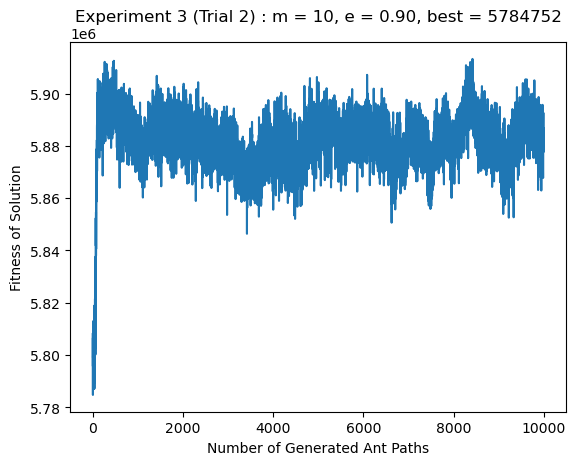

In [17]:
start_e3_t2 = timeit.default_timer()

aco_e3_t2 = AntColony(distance_matrix, pheromone_array, 10, 10000, 0.9)
overall_lowest_e3_t2, fitnesses_e3_t2 = aco_e3_t2.run()

end_e3_t2 = timeit.default_timer()

print("Overall Best Fitness: " + str(overall_lowest_e3_t2[-1]))
print("Time Used: " + str(end_e3_t2 - start_e3_t2) + " seconds")

plt.plot(fitnesses_e3_t2)
title = "Experiment 3 (Trial 2) : m = 10, e = 0.90, best = " + str(overall_lowest_e3_t2[-1])
plt.title(title, pad = 15.0)
plt.ylabel('Fitness of Solution')
plt.xlabel('Number of Generated Ant Paths')
plt.savefig("aco_e3_t2.png")
plt.show()

Trial 3

Overall Best Fitness: 5770629
Time Used: 70.10846637499981 seconds


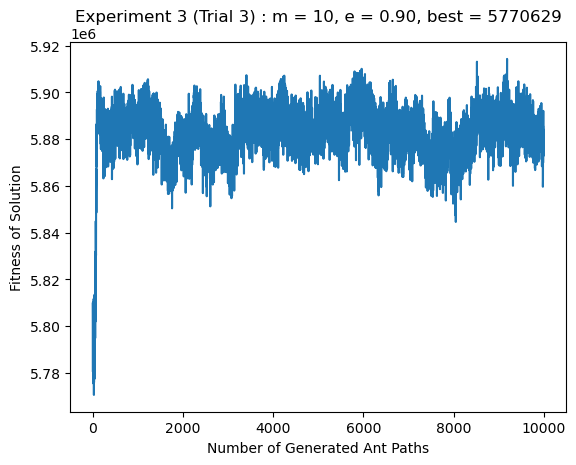

In [18]:
start_e3_t3 = timeit.default_timer()

aco_e3_t3 = AntColony(distance_matrix, pheromone_array, 10, 10000, 0.9)
overall_lowest_e3_t3, fitnesses_e3_t3 = aco_e3_t3.run()

end_e3_t3 = timeit.default_timer()

print("Overall Best Fitness: " + str(overall_lowest_e3_t3[-1]))
print("Time Used: " + str(end_e3_t3 - start_e3_t3) + " seconds")

plt.plot(fitnesses_e3_t3)
title = "Experiment 3 (Trial 3) : m = 10, e = 0.90, best = " + str(overall_lowest_e3_t3[-1])
plt.title(title, pad = 15.0)
plt.ylabel('Fitness of Solution')
plt.xlabel('Number of Generated Ant Paths')
plt.savefig("aco_e3_t3.png")
plt.show()

Trial 4

Overall Best Fitness: 5774186
Time Used: 70.60484016600003 seconds


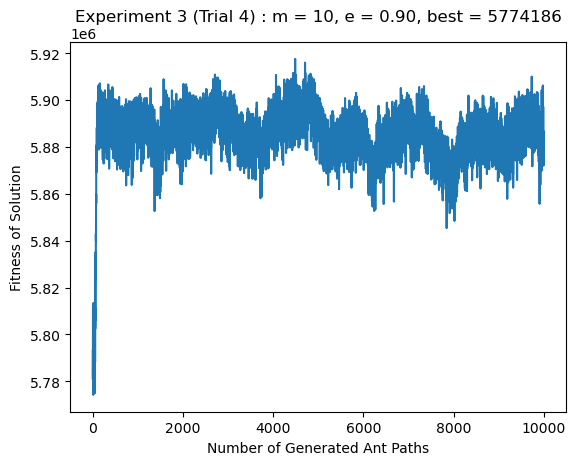

In [19]:
start_e3_t4 = timeit.default_timer()

aco_e3_t4 = AntColony(distance_matrix, pheromone_array, 10, 10000, 0.9)
overall_lowest_e3_t4, fitnesses_e3_t4 = aco_e3_t4.run()

end_e3_t4 = timeit.default_timer()

print("Overall Best Fitness: " + str(overall_lowest_e3_t4[-1]))
print("Time Used: " + str(end_e3_t4 - start_e3_t4) + " seconds")

plt.plot(fitnesses_e3_t4)
title = "Experiment 3 (Trial 4) : m = 10, e = 0.90, best = " + str(overall_lowest_e3_t4[-1])
plt.title(title, pad = 15.0)
plt.ylabel('Fitness of Solution')
plt.xlabel('Number of Generated Ant Paths')
plt.savefig("aco_e3_t4.png")
plt.show()

Trial 5

Overall Best Fitness: 5773848
Time Used: 69.66862812499949 seconds


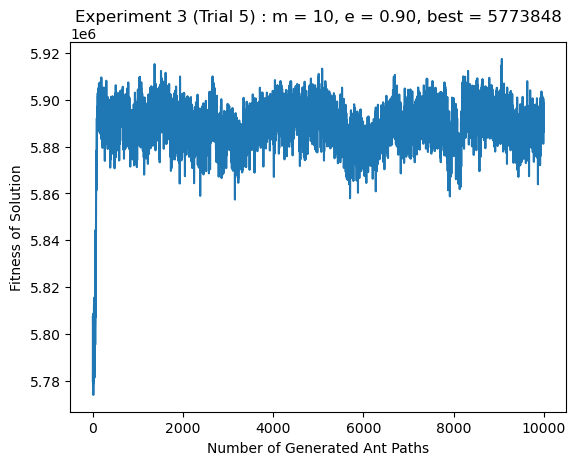

In [20]:
start_e3_t5 = timeit.default_timer()

aco_e3_t5 = AntColony(distance_matrix, pheromone_array, 10, 10000, 0.9)
overall_lowest_e3_t5, fitnesses_e3_t5 = aco_e3_t5.run()

end_e3_t5 = timeit.default_timer()

print("Overall Best Fitness: " + str(overall_lowest_e3_t5[-1]))
print("Time Used: " + str(end_e3_t5 - start_e3_t5) + " seconds")

plt.plot(fitnesses_e3_t5)
title = "Experiment 3 (Trial 5) : m = 10, e = 0.90, best = " + str(overall_lowest_e3_t5[-1])
plt.title(title, pad = 15.0)
plt.ylabel('Fitness of Solution')
plt.xlabel('Number of Generated Ant Paths')
plt.savefig("aco_e3_t5.png")
plt.show()

# Experiment 4 (m = 10, e = 0.50)

Trial 1

Overall Best Fitness: 5792136
Time Used: 69.58462237499953 seconds


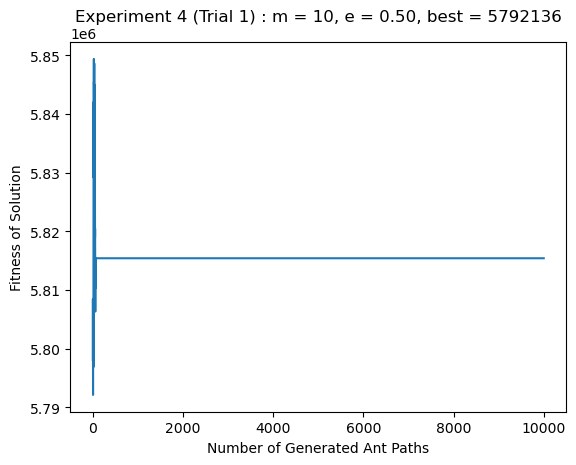

In [21]:
start_e4_t1 = timeit.default_timer()

aco_e4_t1 = AntColony(distance_matrix, pheromone_array, 10, 10000, 0.5)
overall_lowest_e4_t1, fitnesses_e4_t1 = aco_e4_t1.run()

end_e4_t1 = timeit.default_timer()

print("Overall Best Fitness: " + str(overall_lowest_e4_t1[-1]))
print("Time Used: " + str(end_e4_t1 - start_e4_t1) + " seconds")

plt.plot(fitnesses_e4_t1)
title = "Experiment 4 (Trial 1) : m = 10, e = 0.50, best = " + str(overall_lowest_e4_t1[-1])
plt.title(title, pad = 15.0)
plt.ylabel('Fitness of Solution')
plt.xlabel('Number of Generated Ant Paths')
plt.savefig("aco_e4_t1.png")
plt.show()

Trial 2

Overall Best Fitness: 5780333
Time Used: 69.55270629199913 seconds


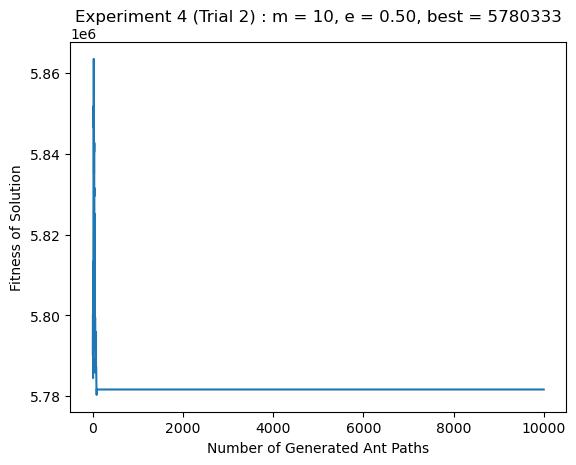

In [22]:
start_e4_t2 = timeit.default_timer()

aco_e4_t2 = AntColony(distance_matrix, pheromone_array, 10, 10000, 0.5)
overall_lowest_e4_t2, fitnesses_e4_t2 = aco_e4_t2.run()

end_e4_t2 = timeit.default_timer()

print("Overall Best Fitness: " + str(overall_lowest_e4_t2[-1]))
print("Time Used: " + str(end_e4_t2 - start_e4_t2) + " seconds")

plt.plot(fitnesses_e4_t2)
title = "Experiment 4 (Trial 2) : m = 10, e = 0.50, best = " + str(overall_lowest_e4_t2[-1])
plt.title(title, pad = 15.0)
plt.ylabel('Fitness of Solution')
plt.xlabel('Number of Generated Ant Paths')
plt.savefig("aco_e4_t2.png")
plt.show()

Trial 3

Overall Best Fitness: 5776702
Time Used: 70.47176754100019 seconds


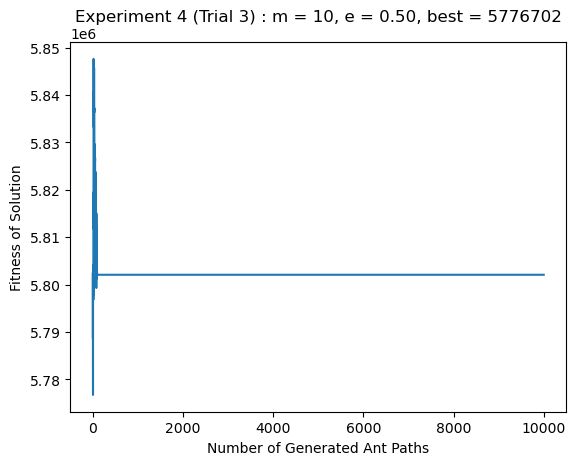

In [23]:
start_e4_t3 = timeit.default_timer()

aco_e4_t3 = AntColony(distance_matrix, pheromone_array, 10, 10000, 0.5)
overall_lowest_e4_t3, fitnesses_e4_t3 = aco_e4_t3.run()

end_e4_t3 = timeit.default_timer()

print("Overall Best Fitness: " + str(overall_lowest_e4_t3[-1]))
print("Time Used: " + str(end_e4_t3 - start_e4_t3) + " seconds")

plt.plot(fitnesses_e4_t3)
title = "Experiment 4 (Trial 3) : m = 10, e = 0.50, best = " + str(overall_lowest_e4_t3[-1])
plt.title(title, pad = 15.0)
plt.ylabel('Fitness of Solution')
plt.xlabel('Number of Generated Ant Paths')
plt.savefig("aco_e4_t3.png")
plt.show()

Trial 4

Overall Best Fitness: 5783293
Time Used: 69.92744379099986 seconds


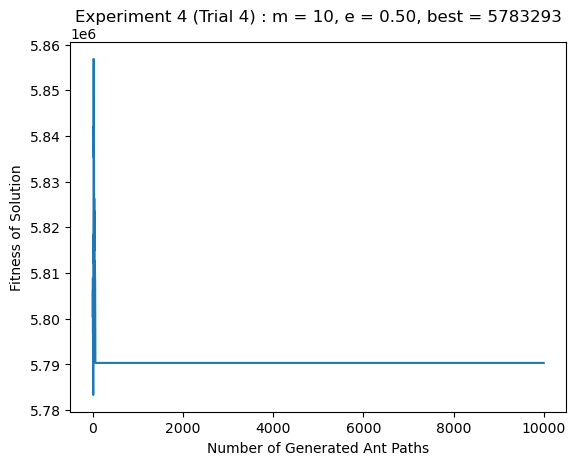

In [24]:
start_e4_t4 = timeit.default_timer()

aco_e4_t4 = AntColony(distance_matrix, pheromone_array, 10, 10000, 0.5)
overall_lowest_e4_t4, fitnesses_e4_t4 = aco_e4_t4.run()

end_e4_t4 = timeit.default_timer()

print("Overall Best Fitness: " + str(overall_lowest_e4_t4[-1]))
print("Time Used: " + str(end_e4_t4 - start_e4_t4) + " seconds")

plt.plot(fitnesses_e4_t4)
title = "Experiment 4 (Trial 4) : m = 10, e = 0.50, best = " + str(overall_lowest_e4_t4[-1])
plt.title(title, pad = 15.0)
plt.ylabel('Fitness of Solution')
plt.xlabel('Number of Generated Ant Paths')
plt.savefig("aco_e4_t4.png")
plt.show()

Trial 5

Overall Best Fitness: 5758576
Time Used: 70.6954336660001 seconds


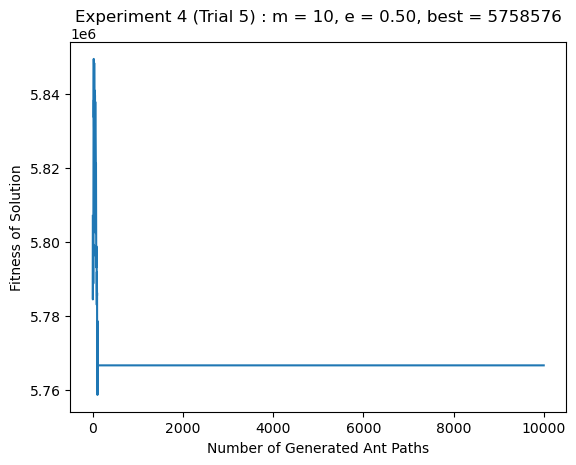

In [25]:
start_e4_t5 = timeit.default_timer()

aco_e4_t5 = AntColony(distance_matrix, pheromone_array, 10, 10000, 0.5)
overall_lowest_e4_t5, fitnesses_e4_t5 = aco_e4_t5.run()

end_e4_t5 = timeit.default_timer()

print("Overall Best Fitness: " + str(overall_lowest_e4_t5[-1]))
print("Time Used: " + str(end_e4_t5 - start_e4_t5) + " seconds")

plt.plot(fitnesses_e4_t5)
title = "Experiment 4 (Trial 5) : m = 10, e = 0.50, best = " + str(overall_lowest_e4_t5[-1])
plt.title(title, pad = 15.0)
plt.ylabel('Fitness of Solution')
plt.xlabel('Number of Generated Ant Paths')
plt.savefig("aco_e4_t5.png")
plt.show()